# Analiza danych przestrzennych - ćwiczenia laboratoryjne 2022/2023

Ten notatnik zalicza się do grupy zestawów zadań, na podstawie których odbywa się zaliczenie ćwiczeń i podlega zwrotowi do oceny w ustalonym na zajęciach terminie.

Uwagi ogólne:
- Podczas wykonywania zadań należy korzystać wyłącznie z pakietów zaimportowanych na początku notatnika oraz z pakietów wchodzących w skład standardowej biblioteki Pythona, które można zaimportować samodzielnie we wskazanej komórce.
- Swoje rozwiązania należy wprowadzać wyłącznie w miejce następujących fragmentów kodu:<br/> ` # YOUR CODE HERE`<br/> ` raise NotImplementedError()`<br/> Nie należy w żaden sposób modyfikować pozostałych fragmentów kodu oraz elementów notatnika, w szczególności dodawać lub usuwać komórek oraz zmieniać nazwy pliku.
- Jeżeli zestaw zadań wymaga skorzystania z funkcji przygotowanych w ramach wcześniejszych zestawów zadań należy je umieścić we wskazanej komórce.
- Wszystkie wykresy powinny być wykonane w jednolitym, przejrzystym i czytelnym stylu, mieć nadane tytuły, opisane osie oraz odpowiednio dobrany rozmiar, wielkość punktów i grubość linii. Proporcje osi wykresów przedstawiających rozkłady punktów powinny być dobrane tak, aby wykresy odzwierciedlały rzeczywisty rozkład punktów w przestrzeni.
- Zadania, które powodują wyświetlenie komunikatu o błędzie przerywającym wykonywanie kodu nie podlegają ocenie.

Przed odesłaniem zestawu zadań do oceny proszę uzupełnić komórkę z danymi autorów rozwiązania (`NAME` - nazwa grupy, `COLLABORATORS` - imiona, nazwiska i numery indeksów członków grupy) oraz upewnić się, że notatnik działa zgodnie z oczekiwaniami. W tym celu należy skorzystać z opcji **Restart Kernel and Run All Cells...** dostępnej na górnej belce notatnika pod symbolem $\blacktriangleright\blacktriangleright$. 

In [2]:
NAME = "GIN21"
COLLABORATORS = "Szymon Marczak 405302, Dawid Makowski 407894, Tomasz Sanicki 408056"

---

## Zestaw zadań 6: Klasteryzacja, agregacja i autokorelacja danych

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ["OMP_NUM_THREADS"] = '1'
from sklearn.cluster import KMeans

In [4]:
# Miejsce do importu pakietów wchodzących w skład standardowej biblioteki Pythona oraz ustawienie opcji wykorzystywanych pakietów
sns.set() 
sns.set_theme(style="whitegrid")

In [5]:
# Miejsce do wklejenie funkcji ze wcześniejszych zestawów zadań
# YOUR CODE HERE
#Proces rergularny

def regular_on_rectangle(grid, random_component, x_lim, y_lim):
    
    tab = np.zeros((grid[0]*grid[1],2)) #tworzę tablicę dla procesu regularnego ze współrzędnymi punktów w tym procesie (incjalizacja zerami)
    dx = (x_lim[1] - x_lim[0]) / grid[0] #ustalam odległość w płaszczyźnie x w równomiernej siatce punktów
    dy = (y_lim[1] - y_lim[0]) / grid[1] #ustalam odległość w płaszczyźnie y w równomiernej siatce punktów
    for i in range(0,grid[0]): #pętla przebiegająca poziomo po punktach
        for j in range(0,grid[1]): #pętla przebiegająca po każdej kolumnie punktów
            #współrzędna punktu = połowa odległości dx/dy (dla początku) + odległość dx razy iteracja + element losowy (w zakresie +-random_component)
            tab[grid[1]*i+j,0] = dx * (i + 0.5) + random_component*(np.random.rand()-0.5)*dx
            tab[grid[1]*i+j,1] = dy * (j + 0.5) + random_component*(np.random.rand()-0.5)*dy
    return tab #zwracam tablicę

#Proces nieregularny o jednorodnej intennsywności

def homogeneous_poisson_on_rectangle(intensity, x_lim, y_lim):
    
    x = np.random.poisson(intensity*x_lim[1]*y_lim[1]) #generuję proces Poissona o liczbie punktów wg wzoru liczba = intensywność * pole
    tab = np.zeros((x,2)) #tworzę tablicę zer z tą liczbą punktów
    #Współrzęna = Element losowy w zakresie (zakres = rand(0,1) * (góra - dół) + dół)
    tab[:,0] += [np.random.rand() * (x_lim[1] - x_lim[0]) + x_lim[0] for i in range(x)]
    tab[:,1] += [np.random.rand() * (y_lim[1] - y_lim[0]) + y_lim[0] for i in range(x)]
    return tab #zwracam tablicę współrzędnych

#Proces nieregularny o niejednorodnej intensywności
    
def intensity_function (x,y):
    z = 10*(np.cos(np.pi*x/4)+1)
    return z

def unhomogeneous_poisson_on_rectangle(intensity_function, x_lim, y_lim):

    #Tworzę dwie tablice przechowujące 100 liczb między skrajnymi wartościami wspołrzędnych razem tworzących siatkę 100x100
    #(potrzebne będzie do określenia maksymalnej wartości intensywności funkcji)
    x1 = np.array(list(np.linspace(x_lim[0],x_lim[1],100))) #tablica stu liczb 
    y1 = np.array(list(np.linspace(y_lim[0],y_lim[1],100))) #tablica stu liczb
    intensywnosc = max(intensity_function(x1, y1)) #obliczam intensywność funkcji, intensity_function zwraca tablicę wartości tej funkcji i wyłaniamy największą wartość
    x = np.random.poisson(intensywnosc*x_lim[1]*y_lim[1]) #generuję liczbę punktów losowych
    tab = np.zeros((x,2)) #tworzę tablicę zer z tą liczbą punktów
    indeks = 0 #zmienna iterująca po tablicy punktów procesu potomnego zlicza niezerowe punkty tablicy (punkty zerowe są tworzone kiedy nie spełniają warunku w pętli)
    for i in range(x):
        #Współrzęna = Element losowy w zakresie (zakres = rand(0,1) * (góra - dół) + dół)
        tab[indeks,0] += np.random.rand() * (x_lim[1] - x_lim[0]) + x_lim[0] 
        tab[indeks,1] += np.random.rand() * (y_lim[1] - y_lim[0]) + y_lim[0]
        #Zgodnie ze wzorem sprawdzam prawdopodobieństwo
        if 1 - intensity_function(tab[indeks,0],tab[indeks,1]) / intensywnosc > np.random.rand():
            #Punktom niepasującym przuspiuję zero
            tab[indeks,:] = 0
        else:
            indeks += 1
    tab_kon = np.zeros((indeks,2)) #tablica zawierająca wynik końcowy w postaci niezerowych punktów procesu
    for i in range(indeks):
        tab_kon[i,:] += tab[i,:] #przypisuję niezerowe wartości procesu potomnego do tablicy (ostatnie wiersze tablicy tab są zerowe)
    return tab_kon #zwracam tablicę współrzędnych
    
#Proces Materna

def materna_on_rectangle(parent_intensity, daughter_intensity, cluster_radius, x_lim, y_lim):

    x = np.random.poisson(parent_intensity*x_lim[1]*y_lim[1]) #generuję proces rodzicielski
    tab = np.zeros((x,2)) #tablica w której zapiszę punkty procesu rodzicielskiego
    tab[:,0] += [np.random.rand() * (x_lim[1] - x_lim[0]) + x_lim[0] for i in range(x)] #współrzędna x punktów procesu rodzicielskiego
    tab[:,1] += [np.random.rand() * (y_lim[1] - y_lim[0]) + y_lim[0] for i in range(x)] #współrzędna y punktów procesu rodzicielskiego
    tab_kluster = np.zeros((x*int(daughter_intensity*np.pi*cluster_radius**2),2)) #generuję proces potomny
    indeks = 0 #zmienna iterująca po tablicy punktów procesu potomnego zlicza niezerowe punkty tablicy (punkty zerowe są tworzone kiedy wychodzą poza zakres)
    liczba_punktow_procesu = int(daughter_intensity*np.pi*cluster_radius**2) #liczba punktów procesu potomnego dla pętli for
    for i in range(x): #pętla przebiegająca po każdym skupieniu (przypada na jeden proces rodzicielski)
        for j in range(liczba_punktow_procesu): #pętla przebiegająca po każdym punkcie w danym skupieniu
            #Generuję punkt w procesie równomiernego rozłożenia w kole
            p = np.random.rand() * 2 * np.pi #losowy kąt
            r = cluster_radius * np.sqrt(np.random.rand()) #losowy promień
            x_wsp_rand = np.cos(p) * r #współrzędna x punktu w kole względem jego środka
            y_wsp_rand = np.sin(p) * r #współrzędna y punktu w kole względem jego środka
            #żeby wpisać współrzędne punktu do tablicy muszę dodać współrzędne środka koła
            tab_kluster[indeks,0] += x_wsp_rand + tab[i,0] #dla x
            tab_kluster[indeks,1] += y_wsp_rand + tab[i,1] #dla y
            #Warunek czy dany punkt znajduje się w zakresie ustalonym w parametrach funkcji (x_lim i y_lim)
            if tab_kluster[indeks,0] > x_lim[1] or tab_kluster[indeks,1] > y_lim[1] or tab_kluster[indeks,0] < x_lim[0] or tab_kluster[indeks,1] < y_lim[0]:
                #jeśli tak to punktowi przypisuję zera (które później zostaną nadpisane, ponieważ nie przesuwam indeksu)
                tab_kluster[indeks,0] = 0
                tab_kluster[indeks,1] = 0
            else:
                #jeśli nie to przesuwam indeks
                indeks += 1
    tab_kon = np.zeros((indeks,2)) #tablica zawierająca wynik końcowy w postaci niezerowych punktów procesu potomnego
    for i in range(indeks):
        tab_kon[i,:] += tab_kluster[i,:] #przypisuję niezerowe wartości procesu potomnego do tablicy (ostatnie wiersz tab_kluster są zerowe)
    return tab_kon #funkcja zwraca tablicę ze współrzędnymi punktów procesu punktowego

#Proces Thomasa

def thomas_on_rectangle(parent_intensity, mean_cluster_size, cluster_sigma, x_lim, y_lim):
    
    x = np.random.poisson(parent_intensity*x_lim[1]*y_lim[1]) #generuję proces rodzicielski
    tab = np.zeros((x,2)) #tablica w której zapiszę punkty procesu rodzicielskiego
    tab[:,0] += [np.random.rand() * (x_lim[1] - x_lim[0]) + x_lim[0] for i in range(x)] #współrzędna x punktów procesu rodzicielskiego
    tab[:,1] += [np.random.rand() * (y_lim[1] - y_lim[0]) + y_lim[0] for i in range(x)] #współrzędna y punktów procesu rodzicielskiego
    liczba_punktow_procesu = np.zeros((x,), dtype=int) #tworzę tablicę ile elementów będzie zawierało dane skupienie
    for i in range(x):
        liczba_punktow_procesu[i] = int(np.random.poisson(mean_cluster_size)) #liczba punktów procesu potomnego dla każdego skupienia
    tab_kluster = np.zeros((sum(liczba_punktow_procesu),2)) #tablica współrzędnych punktów procesu potomnego wszystkich skupień
    indeks = 0 #zmienna iterująca po tablicy punktów procesu potomnego zlicza niezerowe punkty tablicy (punkty zerowe są tworzone kiedy wychodzą poza zakres)
    for i in range(x): #pętla przebiegająca po każdym skupieniu (przypada na jeden proces rodzicielski)
        for j in range(liczba_punktow_procesu[i]): #pętla przebiegająca po każdym punkcie w danym skupieniu (tu zakres inny dla każdego skupienia)
            #Generuję losową zmienną dla współrzędnych z rozkładu losowego
            x_wsp_rand = np.random.normal(0, cluster_sigma) #dla x
            y_wsp_rand = np.random.normal(0, cluster_sigma) #dla y
            #Żeby wpisać współrzędne punktu do tablicy muszę dodać współrzędne środka koła
            tab_kluster[indeks,0] += x_wsp_rand + tab[i,0] #dla x
            tab_kluster[indeks,1] += y_wsp_rand + tab[i,1] #dla y
            #Warunek czy dany punkt znajduje się w zakresie ustalonym w parametrach funkcji (x_lim i y_lim)
            if tab_kluster[indeks,0] > x_lim[1] or tab_kluster[indeks,1] > y_lim[1] or tab_kluster[indeks,0] < x_lim[0] or tab_kluster[indeks,1] < y_lim[0]:
                #jeśli tak to punktowi przypisuję zera (które później zostaną nadpisane, ponieważ nie przesuwam indeksu)
                tab_kluster[indeks,0] = 0
                tab_kluster[indeks,1] = 0
            else:
                #jeśli nie to przesuwam indeks
                indeks += 1
    tab_kon = np.zeros((indeks,2)) #tablica zawierająca wynik końcowy w postaci niezerowych punktów procesu potomnego
    for i in range(indeks):
        tab_kon[i,:] += tab_kluster[i,:] #przypisuję niezerowe wartości procesu potomnego do tablicy (ostatnie wiersz tab_kluster są zerowe)
    return tab_kon #funkcja zwraca tablicę ze współrzędnymi punktów procesu punktowego

tab_homo_poisson = homogeneous_poisson_on_rectangle(20, [-10,10], [-5,5])
tab_unhom_poisson = unhomogeneous_poisson_on_rectangle(intensity_function, [-10,10], [-5,5])
tab_matern = materna_on_rectangle(0.3, 15, 1.25, [-10,10], [-5,5])
tab_thomas = thomas_on_rectangle(0.3, 20, 0.75, [-10,10], [-5,5])

#raise NotImplementedError()
#raise NotImplementedError()

### Przygotowanie danych
Wczytaj dane zawarte w plikach CSV załączonych do zestawu zadań.

In [6]:
# YOUR CODE HERE
tab1=pd.read_csv("points_1.csv")
tab2=pd.read_csv("points_2.csv")
tab3=pd.read_csv("points_3.csv")
#raise NotImplementedError()

### Zadanie 1: Klasteryzacja metodą k-średnich (11 pkt)

Przygotuj funkcję `k_means_elbow_curve_test()`, która będzie wykonywała klasteryzację danych dla ustalonego zakresu liczby klastrów oraz obliczała dane niezbędne do wykreślenia wykresu typu elbow curve, na podstawie którego można podjąć decyzję na temat optymalnej liczby klastrów.

Następnie wykorzystaj przygotowaną funkcję do podzielenia na optymalną liczbę klastrów rozkładu punktów z pliku points_1.csv. 

Przedstaw wyniki analizy graficznie w postaci wykresu liniowego (elbow curve) oraz rozkładu punktów podzielonego na optymalną liczbę klastrów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 1x2).

#### a) Przygotowanie funkcji

In [7]:
def k_means_elbow_curve_test(points, number_of_clusters):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    number_of_clusters: list
        Lista określająca zakres testowanej liczby klastrów.
        Przykład: [1, 5]   

    Returns
    -------
    clusters: DataFrame
        Tablica zbierająca wyniki klasteryzacji w następujących kolumnach:
        - "X" - współrzędne X punktów,
        - "Y" - współrzedne Y punktów,
        - kolejne kolumny (ich liczba zależy od liczby testowanych liczebności klastrów) opisane są jako liczba klastrów,
        np. "1", "2", itd. i zawierają numery klastrów, do których zostały przyporządkowane konkretne punkty.
    elbow_curve: DataFrame
        Tablica zbierająca dane niebędne do wykonania wykresu elbow curve w dwóch kolumnach:
        - "N" - liczba klastrów,
        - "D(N)" - średnia odległość punktu od centrum klastra, do którego jest przypisany.
    """
    # YOUR CODE HERE
    clusters = points.copy()
    elbow_curve = pd.DataFrame()
    DN = np.zeros(number_of_clusters[1]) #Tablica D(N) do DataFrame'a elbow_curve
    for i in range(number_of_clusters[0], number_of_clusters[1] + 1): #Pętla przebiegająca po każdej ilości skupień
        kmeans = KMeans(n_clusters = i).fit(points) #Funkcja przypisująca punkty do skupienia
        klastry = kmeans.labels_ #Który punkt do jakiego klastra należy
        clusters.insert(i + 1, i, klastry) #Dołączam do (i+1)- tej kolumny kolumnę o nazwie i-tej liczby
        centers = kmeans.cluster_centers_ #współrzędne środków skupień
        avg_global = 0 #średnia dla wszystkich klastrów (dla danej ilości skupień)
        for j in range(number_of_clusters[0], i + 1): #Pętla licząca w każdym klastrze średnią odegłość do środka (dla i klastrów)
            avg = 0 #Średnia lokalna dla każdego skupienia
            div = 0 #Ilość punktów w danym klastrze
            for k in range(len(points)): #Pętla licząca odległość każdego punktu w klastrze (warunek) od środka
                if klastry[k] == j - 1: #Jeśli punkt należy do danego klastra
                    avg += np.sqrt((points['X'][k] - centers[j - 1][0])**2 + (points['Y'][k] - centers[j - 1][1])**2) #Wzór na odległość
                    div += 1 #Dodaję, żeby wyszła liczba punktów
            avg /= div #Liczę średnią dzieląc sumę
            avg_global += avg #Dodaję sumę lokalną do sumy globalnej
        avg_global /= i #Liczę średnią globalną jako średnią średnich lokalnych
        DN[i - 1] = avg_global #Przypisuję wynik do tablicy DN
            
    elbow_curve.insert(0, 'N', range(number_of_clusters[0], number_of_clusters[1] + 1)) #Dołączam tablicę N do DataFrame'a
    elbow_curve.insert(1,'D(N)', DN) #Dołączam tablicę D(N) do DataFrame'a
    return clusters, elbow_curve
    #raise NotImplementedError()

#### b) Wygenerowanie danych

In [8]:
# YOUR CODE HERE
[clu1, elb1] = k_means_elbow_curve_test(tab1, [1,10])
#raise NotImplementedError()

#### c) Wizualizacja

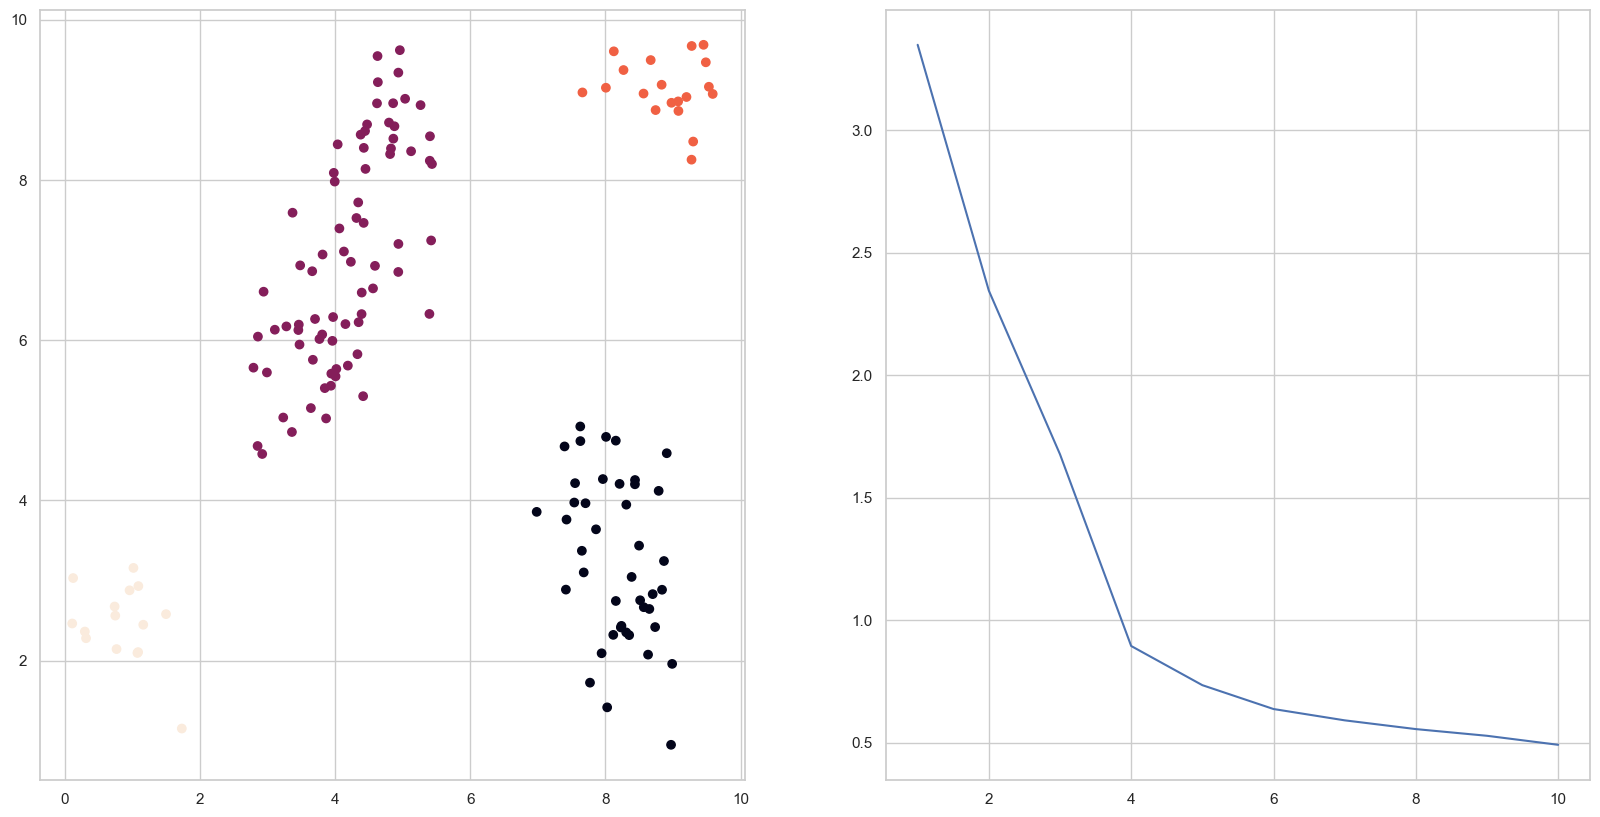

In [9]:
# YOUR CODE HERE
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20,10))
axs[0].scatter(data = clu1, x = 'X', y = 'Y', c = clu1[4])
axs[1].plot(elb1['N'], elb1['D(N)'])
#raise NotImplementedError()

### Zadanie 2: Agregacja danych na siatce prostokątnej (6 pkt)

Przygotuj funkcję `agregate_on_rectangles()`, która będzie zliczać punkty w obrębie prostokątnych podobszarów.

Następnie wykorzystaj przygotowaną funkcję do zagregowania rozkładów punktów z plików points_2.csv i points_3.csv. Ustaw podział obszaru na 40 podobszarów wzdłuż osi $x$ i 20 podobszarów wzdłuż osi $y$.

Przedstaw wyniki analizy graficznie w postaci histogramów dwuwymiarowych z nałożonymi na nie rozkładami punktów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 1x2).

#### a) Przygotowanie funkcji

In [13]:
def agregate_on_rectangles(points, bins, x_lim, y_lim):
    """
    Parameters
    -------
    points: DataFrame
        Tablica zawierająca dwie kolumny ze współrzędnymi punktów opisane jako "X" i "Y".
    bins: list
        Lista określająca liczbę podobszarów w poziomie i pionie.
        Przykład: [10, 10]
    x_lim: list
        Lista określająca zakres wartości współrzędnej X.
        Przykład: [0, 10]
    y_lim: list
        Lista określająca zakres wartości współrzędnej Y.
        Przykład: [0, 10]   

    Returns
    -------
    binned_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z liczbą punków przypisanych do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]
    """
    # YOUR CODE HERE
    return np.histogram2d(points['X'], points['Y'], bins = bins, range = [x_lim, y_lim])
    #raise NotImplementedError()

#### b) Wygenerowanie danych

In [14]:
# YOUR CODE HERE
aor2 = agregate_on_rectangles(tab2, [40,20], [0,20], [0,10])
aor3 = agregate_on_rectangles(tab3, [40,20], [0,20], [0,10])
#aise NotImplementedError()

#### c) Wizualizacja

Text(0.5, 0.98, 'Agregowanie danych na siatce prostokątnej')

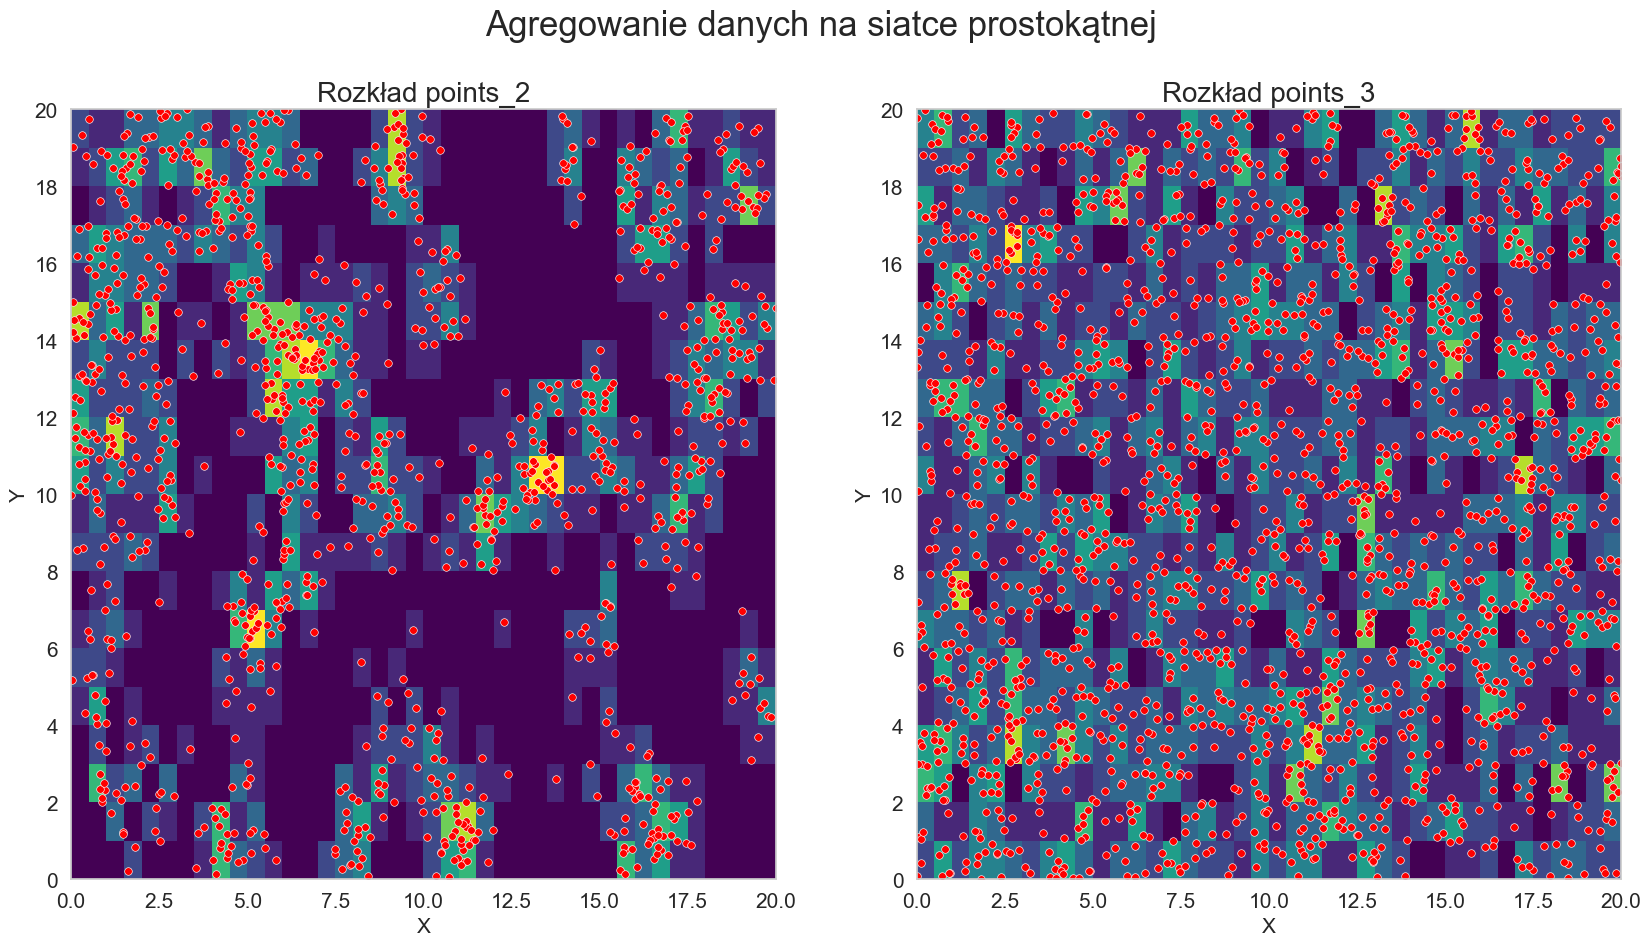

In [15]:
fig = plt.figure(figsize = (20,10))

ax = fig.add_subplot(121)
ax=plt.pcolormesh(aor2[1], aor2[2], aor2[0].T, cmap = 'viridis'), sns.scatterplot(data = tab2, x = tab2['X'], y = tab2['Y'], s = 30,color="red")
plt.title("Rozkład points_2", fontsize = 20)
plt.xlabel('X', fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.yticks(fontsize = 15)
plt.yticks(np.arange(11), range(0,22,2))

ax = fig.add_subplot(122)
ax=plt.pcolormesh(aor3[1], aor3[2], aor3[0].T, cmap = 'viridis'),sns.scatterplot(data = tab3, x = tab3['X'], y = tab3['Y'], s = 30, color = "red")
plt.title("Rozkład points_3", fontsize = 20)
plt.xlabel('X', fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.yticks(fontsize = 15)
plt.yticks(np.arange(11), range(0,22,2))

plt.suptitle("Agregowanie danych na siatce prostokątnej", fontsize = 25)

#raise NotImplementedError()

#### Zadanie 3: Tablica sąsiedztwa (11 pkt)

Przygotuj funkcję `spatial_weights()`, która będzie przygotowywać tablicę sąsiedztwa podobszarów.

Schemat generowania tablicy sąsiedztwa:

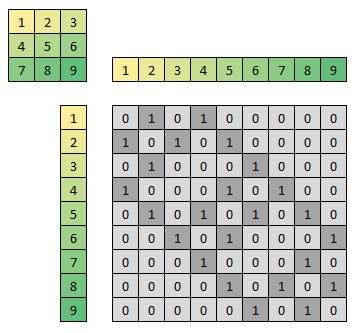

Następnie wykorzystaj przygotowaną funkcję do wykonania tablic sąsiedztwa zagregowanych danych z zadania 2.

Przedstaw wyniki analizy graficznie za pomocą wykresów heatmap. Zestaw wyniki na pojedynczej figurze (siatka wykresów 1x2).

#### a) Przygotowanie funkcji

In [16]:
def spatial_weights(bin_counts):
    """
    Parameters
    -------
    bin_counts: array
        Macierz 2D z liczbą punków przypisanych do każdego z podobszarów.

    Returns
    -------
    w: array
        Macierz 2D zawierająca wagi przestrzenne.
    """    

# YOUR CODE HERE
    sd1 = len(bin_counts[0]) # ilosc podobszarow dla y
    sd2 = len(bin_counts[:,0]) # ilosc podobszaró dla x 
     d = sd1*sd2 # ilsoc wszystkich podoszarow 
    
    w = np.zeros((d,d)) # tablica sasiedstwa wypelniona zerami 
    for i in range (sd1):
        for j in range (sd2):
            ind = i*sd2 + j # wzor na indeks ind= indeks akt*ilosc podobsarow dla x + indejs kolumny 
            if j < sd2 - 1: w[ind][ind + 1] = 1 # jesli indeks kolumny jest mniejszy od ilosci podobszarow dla x -1 
            if j > 0: w[ind][ind - 1] = 1
            if i < sd1 - 1: w[ind][ind + sd1] = 1
            if i > 0: w[ind][ind - sd1] = 1
    return w
    #raise NotImplementedError()

#### b) Wygenerowanie danych

In [17]:
# YOUR CODE HERE
sw1 = spatial_weights(aor2[0])
sw2 = spatial_weights(aor3[0])
#raise NotImplementedError()

20
20


#### c) Wizualizacja

Text(0.5, 0.98, 'Macierze sąsiedztwa')

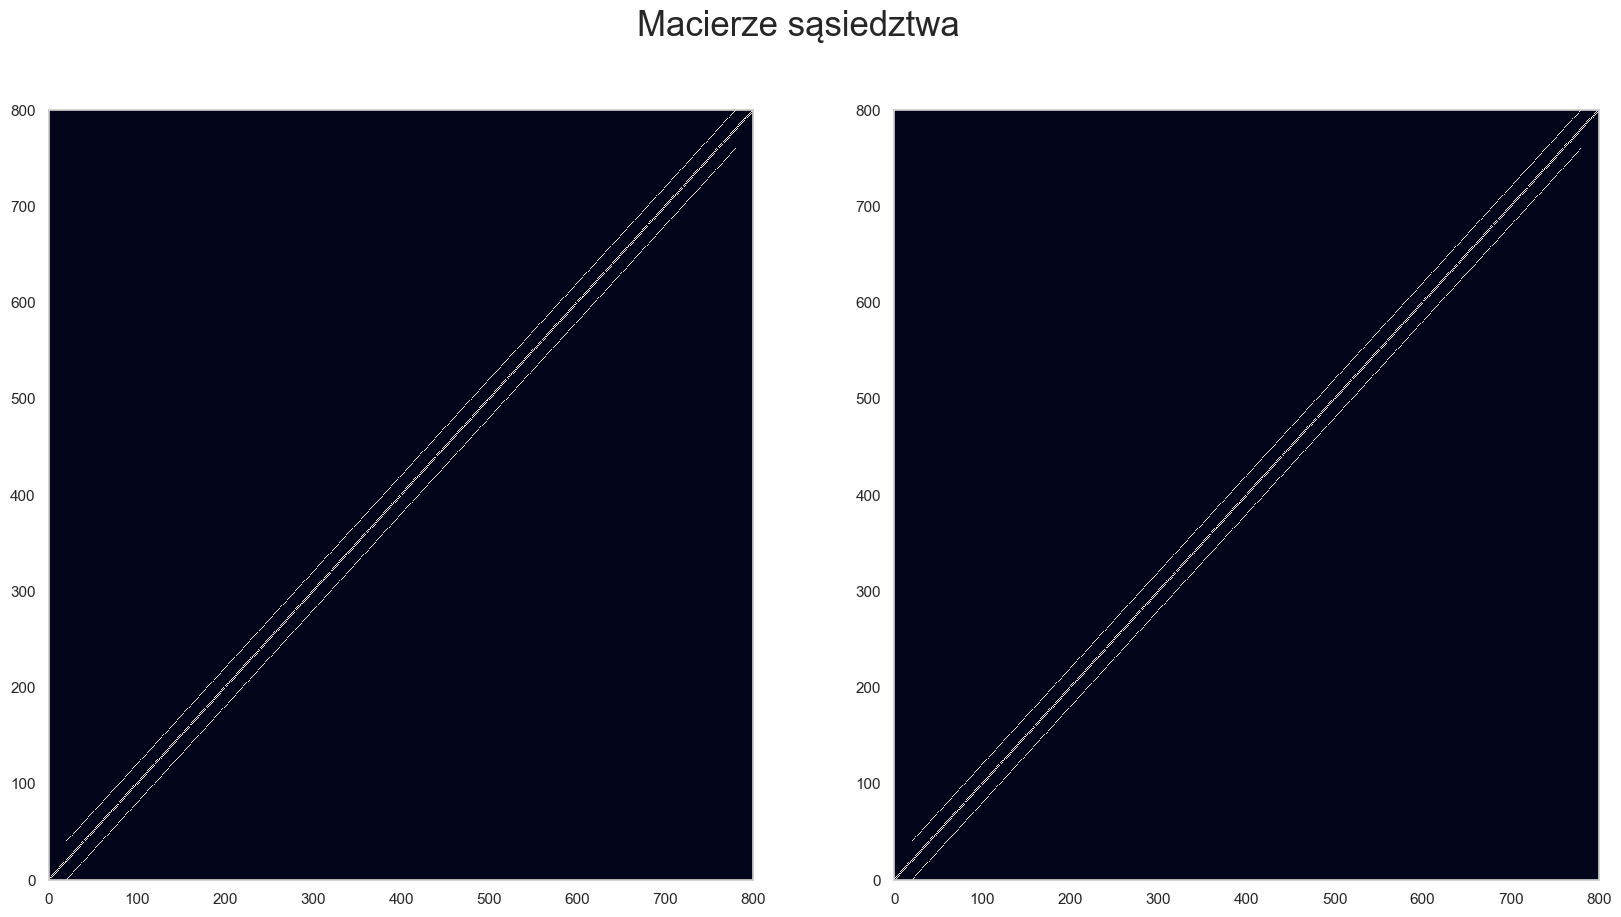

In [18]:
# YOUR CODE HERE
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20,10))
axs[0].pcolormesh(sw1)
axs[1].pcolormesh(sw2)

plt.suptitle("Macierze sąsiedztwa", fontsize = 25)
#raise NotImplementedError()

### Zadanie 4: Opóźnienie przestrzenne (11 pkt)

Przygotuj funkcję `spatial_lag()`, która będzie przygotowywać tablicę wartości opóźnienia przestrzennego.

Następnie wykorzystaj przygotowaną funkcję do wyznaczania tablic opóźnienia przestrzennego zagregowanych danych z zadania 2.

Przedstaw wyniki analizy graficznie w postaci histogramów dwuwymiarowych zestawionych z danymi zagregowanymi na podstawie których zostały one wykonane. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x2). Umieść zagreowane dane w górnym wierszu, a opóźnienie przestrzenne w dolnym wierszu figury.

Algorytm postępowania:
1) Spłaszczamy macierz zliczeń w podobszarach.
2) Obliczamy poszczególne wartości tablicy opóźnienia przestrzennego zgodnie ze wzorem: <br/>
$ LC_{i} = \frac {\sum_j w_{ij} \cdot X_j} {\sum_j w_{ij}}$  <br/>
gdzie: $w$ - macierz sąsiedztwa, $X$ - spłaszczona macierz zliczeń w podobszarach. 
3) Konwertujemy tablicę opóźnienia przestrzennego do tych samych wymiarów jakie miała wejściowa macierz zliczeń w podobszarach.

#### a) Przygotowanie funkcji

In [105]:
def spatial_lag(binned_data):
    """
    Parameters
    -------
    binned_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z liczbą punków przypisanych do każdego z podobszarów.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]

    Returns
    -------
    lagged_data: list
        Lista zawierająca trzy macierze:
        - 1D ze współrzędnymi krawędzi podobszarów na osi X,
        - 1D ze współrzędnymi krawędzi podobszarów na osi Y,
        - 2D z wyliczonymi wartościami opóźnienia przestrzennego.
        Na przykład: [array([0, 1, 2]), array([0, 1, 2]), array([[7, 2], [4, 5]])]
    """    
    # YOUR CODE HERE
    
    sw = spatial_weights(binned_data[0])
    X = binned_data[0].flatten()
    LC = np.zeros(len(sw[0]))
    for i in range (len(sw[0])):
        suma = sum(sw[i])
        for j in range (len(sw[0])):
            LC[i]+=(sw[i][j]*X[j])
        LC[i]/=suma
    #Tworzenie listy wynikowej (potrzeba kopiowania, ponieważ pojedyncze przypisanie jest przez wskaźnik)
    lagged_data = np.empty_like(binned_data)
    lagged_data[0] = binned_data[0].copy()
    lagged_data[1] = binned_data[1].copy()
    lagged_data[2] = binned_data[2].copy()
    
    for i in range (len(binned_data[0])):        
        for j in range (len(binned_data[0][0])):
            lagged_data[0][i][j]=LC[i*len(binned_data[0][0])+j]
    return lagged_data
    #raise NotImplementedError()

#### b) Wygenerowanie danych

In [106]:
# YOUR CODE HERE
sl2 = spatial_lag(aor2)
sl3 = spatial_lag(aor3)
#raise NotImplementedError()

40 40
40 40


#### c) Wizualizacja

C:\Users\gmako\AppData\Local\Temp\ipykernel_1964\2635404357.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax=plt.pcolormesh(aor2[1], aor2[2], aor2[0].T, cmap = 'viridis'), sns.scatterplot(data = tab2, x = tab2['X'], y = tab2['Y'], s = 30,color="red")
C:\Users\gmako\AppData\Local\Temp\ipykernel_1964\2635404357.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax=plt.pcolormesh(aor3[1], aor3[2], aor3[0].T, cmap = 'viridis'),sns.scatterplot(data = tab3, x = tab3['X'], y = tab3['Y'], s = 30, color = "red")
C:\Users\gmako\AppData\Local\Temp\ipykernel_1964\2635404357.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor relea

([<matplotlib.axis.YTick at 0x15b340f0280>,
 [Text(0, 0, '0'),
  Text(0, 1, '2'),
  Text(0, 2, '4'),
  Text(0, 3, '6'),
  Text(0, 4, '8'),
  Text(0, 5, '10'),
  Text(0, 6, '12'),
  Text(0, 7, '14'),
  Text(0, 8, '16'),
  Text(0, 9, '18'),
  Text(0, 10, '20')])

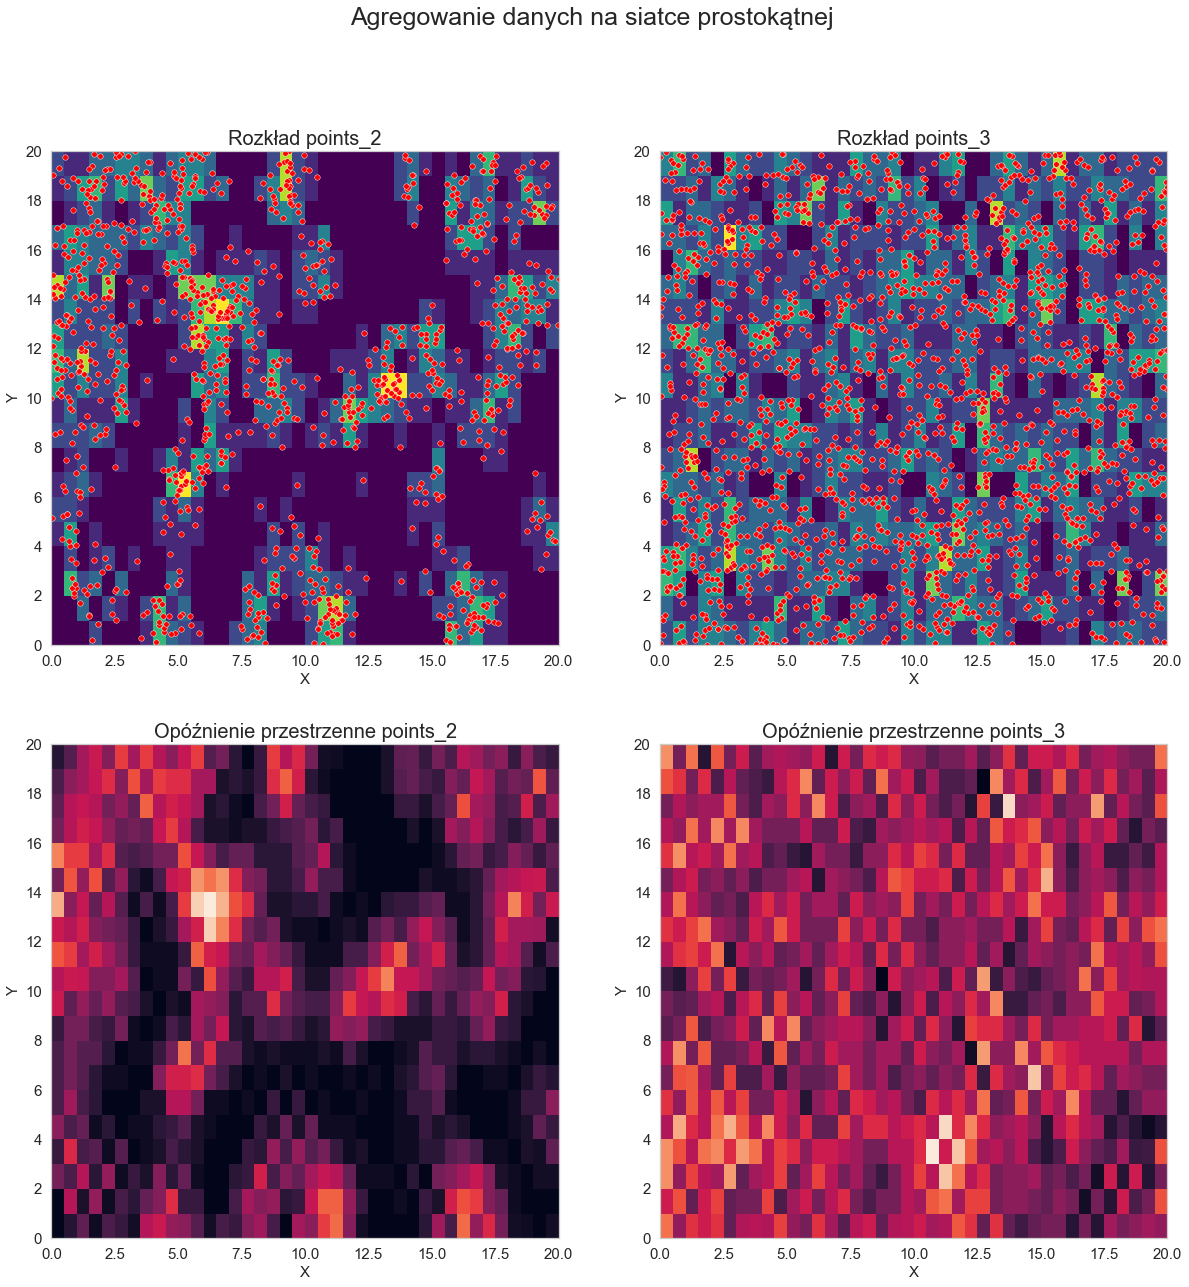

In [111]:
# YOUR CODE HERE

fig = plt.figure(figsize = (20,20))

ax = fig.add_subplot(221)
ax=plt.pcolormesh(aor2[1], aor2[2], aor2[0].T, cmap = 'viridis'), sns.scatterplot(data = tab2, x = tab2['X'], y = tab2['Y'], s = 30,color="red")
plt.title("Rozkład points_2", fontsize = 20)
plt.xlabel('X', fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.yticks(fontsize = 15)
plt.yticks(np.arange(11), range(0,22,2))

ax = fig.add_subplot(222)
ax=plt.pcolormesh(aor3[1], aor3[2], aor3[0].T, cmap = 'viridis'),sns.scatterplot(data = tab3, x = tab3['X'], y = tab3['Y'], s = 30, color = "red")
plt.title("Rozkład points_3", fontsize = 20)
plt.xlabel('X', fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.yticks(fontsize = 15)
plt.yticks(np.arange(11), range(0,22,2))

plt.suptitle("Agregacja danych w siatce prostokątnej", fontsize = 25)

ax=fig.add_subplot(223)
ax=plt.pcolormesh(sl2[1],sl2[2],sl2[0].T)
plt.title("Opóźnienie przestrzenne points_2", fontsize = 20)
plt.xlabel('X', fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.yticks(fontsize = 15)
plt.yticks(np.arange(11), range(0,22,2))

ax=fig.add_subplot(224)
ax=plt.pcolormesh(sl3[1],sl3[2],sl3[0].T)
plt.title("Opóźnienie przestrzenne points_3", fontsize = 20)
plt.xlabel('X', fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.yticks(fontsize = 15)
plt.yticks(np.arange(11), range(0,22,2))

#raise NotImplementedError()

### Zadanie 5: Wykres Morana (11 pkt)

Przygotuj funckję `moran_plot_data()`, która będzie przygotowywać dane niezbędne do wykonania wykresu Morana. Wykres Morana to zestawienie wartości z macierzy zliczeń ustandaryzowanych poprzez odjęcie od nich ich wartości średniej (oś x) z wartościami z macierzy opóźnienia przestrzennego ustandaryzowanych poprzez odjęcie od nich ich wartości średniej (oś y) z nałożoną na nie prostą regresji.

Następnie wykorzystaj przygotowaną funkcję do przygotowanie danych do wykonania wykresu Morana zagregowanych danych z zadania 2. 

Przedstaw wyniki analizy graficznie w postaci wykresów Morana zestawionych z danymi zagregowanymi na podstawie których zostały wykonane przedstawionymi w postaci histogramów dwuwymiarowych z nałożonymi na nie rozkładami punktów. Zestaw wyniki na pojedynczej figurze (siatka wykresów 2x2). Umieść zagreowane dane w górnym wierszu, a wykresy Morana w dolnym wierszu figury.

#### a) Przygotowanie funkcji

In [74]:
def moran_plot_data(bin_counts, lagged_counts):
    """
    Parameters
    -------
    bin_counts: array
        Macierz 2D z liczbą punków przypisanych do każdego z podobszarów.
    lagged_counts: array
        Macierz 2D z wartościami opóźnienia przestrzennego przypisanego do każdego z podobszarów.

    Returns
    -------
    moran_plot_data: DataFrame
        Tablica zawierająca dwie kolumny danych niebędnych do wykonania wykresu Morana:
        - "AG_STD" - ustandarywowane dane zagregowane,
        - "SL_STD" - ustandarywzowane wartości opóźnienia przestrzennego.
        
        Przygotuj funckję moran_plot_data(), która będzie przygotowywać dane niezbędne do wykonania wykresu Morana. 
        Wykres Morana to zestawienie wartości z macierzy zliczeń ustandaryzowanych poprzez odjęcie od nich ich wartości średniej (oś x) 
        z wartościami z macierzy opóźnienia przestrzennego ustandaryzowanych poprzez odjęcie od nich ich wartości średniej (oś y) 
        z nałożoną na nie prostą regresji
    """ 
    # YOUR CODE HERE
    agstd = bin_counts[0] - np.mean(bin_counts[0])
    slstd = lagged_counts[0] - np.mean(lagged_counts[0])
    moran_plot_data = pd.DataFrame({"AG_STD": agstd.flatten(), "SL_STD": slstd.flatten()})
    return moran_plot_data
    #raise NotImplementedError()

#### b) Wygenerowanie danych

In [75]:
# YOUR CODE HERE
moran1 = moran_plot_data(aor2, sl2)
moran2 = moran_plot_data(aor3, sl3)
#raise NotImplementedError()

#### c) Wizualizacja

C:\Users\gmako\AppData\Local\Temp\ipykernel_1964\1585467468.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax= plt.pcolormesh(x[1], x[2], x[0].T, cmap = 'viridis'), sns.scatterplot(data = tab2, x = tab2['X'], y = tab2['Y'], s = 30,color="red")
C:\Users\gmako\AppData\Local\Temp\ipykernel_1964\1585467468.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax  =plt.pcolormesh(y[1], y[2], y[0].T, cmap = 'viridis'),sns.scatterplot(data = tab3, x = tab3['X'], y = tab3['Y'], s = 30, color = "red")
C:\Users\gmako\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing oth

Text(0.5, 0.98, 'Agregowanie danych na siatce prostokątnej')

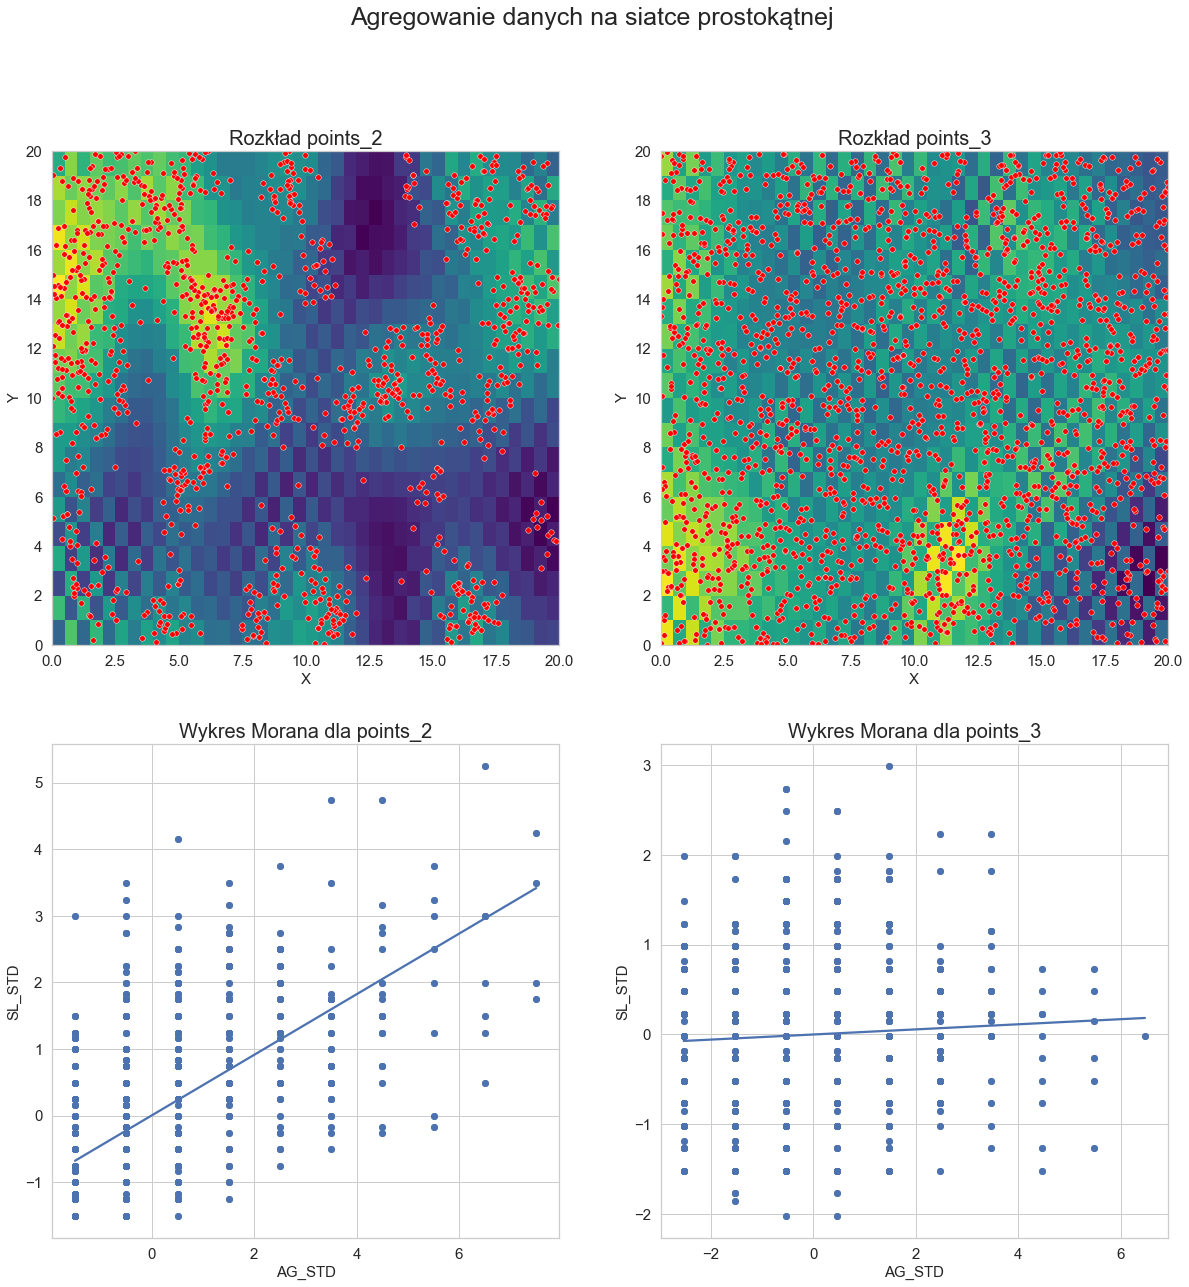

In [121]:
fig = plt.figure(figsize = (20,20))

ax = fig.add_subplot(221)
ax= plt.pcolormesh(x[1], x[2], x[0].T, cmap = 'viridis'), sns.scatterplot(data = tab2, x = tab2['X'], y = tab2['Y'], s = 30,color="red")
plt.title("Rozkład points_2", fontsize = 20)
plt.xlabel('X', fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.yticks(fontsize = 15)
plt.yticks(np.arange(11), range(0,22,2))

ax = fig.add_subplot(222)
ax  =plt.pcolormesh(y[1], y[2], y[0].T, cmap = 'viridis'),sns.scatterplot(data = tab3, x = tab3['X'], y = tab3['Y'], s = 30, color = "red")
plt.title("Rozkład points_3", fontsize = 20)
plt.xlabel('X', fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Y', fontsize = 15)
plt.yticks(fontsize = 15)
plt.yticks(np.arange(11), range(0,22,2))

ax = fig.add_subplot(223)
ax = plt.scatter(moran1["AG_STD"], moran1["SL_STD"])
plt.title("Wykres Morana dla points_2", fontsize = 20)
plt.xlabel('AG_STD', fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('SL_STD', fontsize = 15)
plt.yticks(fontsize = 15)
sns.regplot(moran1["AG_STD"], moran1["SL_STD"], ci=None)

ax = fig.add_subplot(224)
ax = plt.scatter(moran2["AG_STD"], moran2["SL_STD"])
plt.title("Wykres Morana dla points_3", fontsize = 20)
plt.xlabel('AG_STD', fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('SL_STD', fontsize = 15)
plt.yticks(fontsize = 15)
sns.regplot(moran2["AG_STD"], moran2["SL_STD"], ci=None)

plt.suptitle("Agregacja danych w siatce prostokątnej", fontsize = 25)
